In [1]:
import numpy as np
from os.path import expanduser
import os
from scipy.io import savemat
from utils import rolling_window
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib qt

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
def rescale_to_uint8(X):
    X -= np.min(X)
    X = X/(np.max(X)/255.)
    return X

In [3]:
def get_full_field_flicker(period=5, low_contrast=0.1, high_contrast=1.0, sample_rate=30):
    flicker_sequence = np.hstack([low_contrast*np.random.randn(period*sample_rate), 
                               high_contrast*np.random.randn(period*sample_rate),
                              low_contrast*np.random.randn(period*sample_rate)])
    
    # Convert flicker sequence into full field movie
    full_field_flicker = np.outer(flicker_sequence, np.ones((1,50,50)))
    full_field_flicker = full_field_flicker.reshape((flicker_sequence.shape[0], 50, 50))

    # Convert movie to 400ms long samples in the correct format for our model
    #full_field_movies = rolling_window(full_field_flicker, 40)
    #full_field_movies = np.rollaxis(full_field_movies, 2)
    #full_field_movies = np.rollaxis(full_field_movies, 3, 1)
    return full_field_flicker

In [4]:
contrast_stimulus = get_full_field_flicker(period=5)

In [5]:
contrast_stimulus.shape

(450, 50, 50)

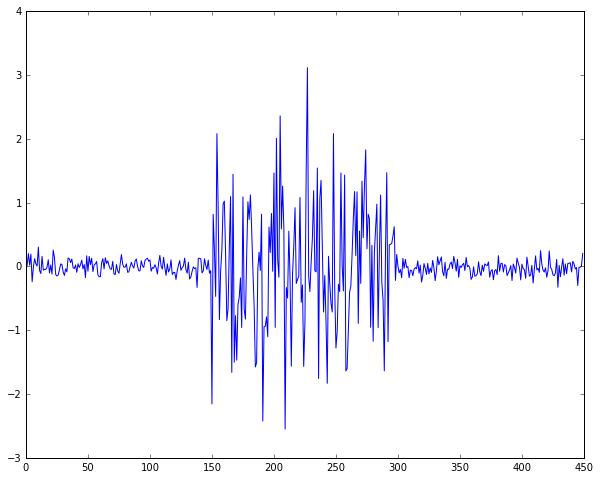

In [6]:
plt.plot(contrast_stimulus[:,0,0])

# Create several movies with high/low contrast of different periods

In [7]:
periods = [2,5]
for p in periods:
    contrast_stimulus = get_full_field_flicker(period=p)
    contrast_stimulus = rescale_to_uint8(contrast_stimulus)
    contrast_stimulus = contrast_stimulus.astype('uint8')
    filename = 'low_high_low_contrast_period_%i.mat' %(p)
    savemat(filename, mdict={'frames':contrast_stimulus})

# Create flash stimuli

In [8]:
def get_flash_sequence(initial_flash=45, latency=10, nsamples=100, intensity=1, flash_length=1):
    flash_sequence = np.zeros((nsamples,))

    # Make two flashes
    for i in range(flash_length):
        flash_sequence[initial_flash+i] = intensity
    if latency < (nsamples - (initial_flash+flash_length)):
        for i in range(flash_length):
            flash_sequence[initial_flash+latency+i] = intensity
    return flash_sequence

In [9]:
def get_full_field_flashes(mask=np.ones((50,50)), initial_flash=60, latency=10, nsamples=100, intensity=1,
                          flash_length=1):
    flash_sequence = get_flash_sequence(initial_flash=initial_flash, latency=latency, nsamples=nsamples,
                                       intensity=intensity, flash_length=flash_length)
    
    # Convert flash sequence into full field movie
    full_field_flash = np.outer(flash_sequence, mask)
    full_field_flash = full_field_flash.reshape((flash_sequence.shape[0], 50, 50))

    # Convert movie to 400ms long samples in the correct format for our model
#     full_field_movies = rolling_window(full_field_flash, 40)
#     full_field_movies = np.rollaxis(full_field_movies, 2)
#     full_field_movies = np.rollaxis(full_field_movies, 3, 1)
    return full_field_flash

In [10]:
stim = get_full_field_flashes(latency=150, nsamples=180, flash_length=2)
stim.shape

(180, 50, 50)

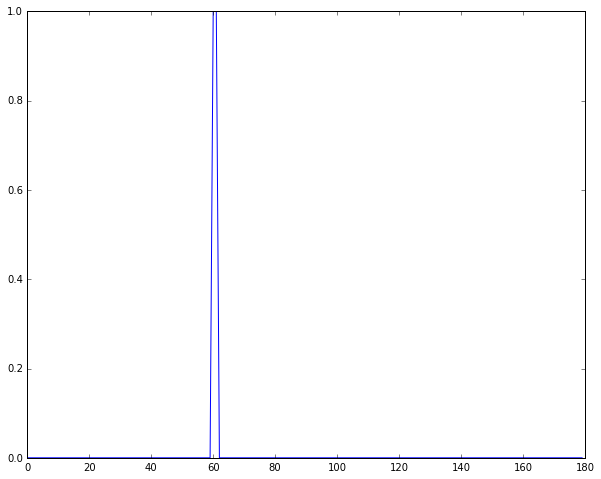

In [11]:
plt.plot(stim[:,0,0])

In [12]:
latencies = [10, 30, 60, 150] # last flash sequence will just have one flash
for l in latencies:
    stim = get_full_field_flashes(latency=l, nsamples=180)
    stim = rescale_to_uint8(stim)
    stim = stim.astype('uint8')
    filename = 'paired_flash_latency_%i_length_%i.mat' %(l, 1)
    savemat(filename, mdict={'frames':stim})

In [13]:
stim = get_full_field_flashes(latency=30, nsamples=180, flash_length=30)
stim = rescale_to_uint8(stim)
stim = stim.astype('uint8')
filename = 'paired_flash_latency_%i_length_%i.mat' %(30, 30)
savemat(filename, mdict={'frames':stim})

In [14]:
# plt.plot(np.random.poisson(.05, 100))

# Reversing gratings

In [23]:
def get_grating_movie(grating_width=1, switch_every=10, movie_duration=100, mask=False, intensity=1, phase=0):
    # make grating
    grating_frame = -1*np.ones((50,50))
    for i in range(grating_width):
        grating_frame[:,(i+phase)::2*grating_width] = 1
    if mask:
        grating_frame = grating_frame * mask * intensity
    else:
        grating_frame = grating_frame * intensity
    
    # make movie
    grating_movie = np.zeros((movie_duration, 50, 50))
    polarity_count = 0
    for frame in range(movie_duration):
        polarity_count += 1
        if int(polarity_count/switch_every) % 2 == 0:
            grating_movie[frame] = grating_frame
        else:
            grating_movie[frame] = -1 * grating_frame
            
#     # roll movie axes to get the right shape
#     full_movies = rolling_window(grating_movie, 40)
#     full_movies = np.rollaxis(full_movies, 2)
#     full_movies = np.rollaxis(full_movies, 3, 1)
    return grating_movie

In [24]:
stim = get_grating_movie(movie_duration=450, switch_every=30)
stim.shape

(450, 50, 50)

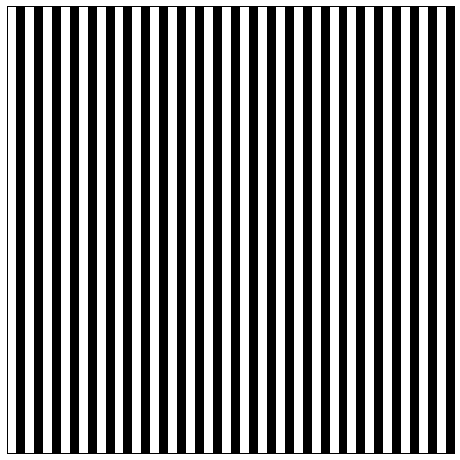

In [29]:
plt.imshow(stim[0,:,:])
plt.xticks([])
plt.yticks([])
plt.savefig('thin_reversing_grating_1.jpg', dpi=100)

In [18]:
widths = [1,5,10,20]
switch_every = [30,60]
dur = 180
for w in widths:
    for s in switch_every:
        stim = get_grating_movie(movie_duration=dur, switch_every=s, grating_width=w)
        stim = rescale_to_uint8(stim)
        stim = stim.astype('uint8')
        filename = 'reversing_gratings_width_%i_switching_%i.mat' %(w,s)
        savemat(filename, mdict={'frames':stim})